In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import glob
from torchvision import transforms
from torch.utils import data
from PIL import Image

In [5]:
img_dir = r'./dataset2/*.jpg'

In [6]:
imgs = glob.glob(img_dir)

In [7]:
imgs[:3]

['./dataset2\\cloudy1.jpg',
 './dataset2\\cloudy10.jpg',
 './dataset2\\cloudy100.jpg']

In [8]:
species = ['cloudy', 'rain', 'shine', 'sunrise']

In [9]:
species_to_idx = dict((c, i) for i, c in enumerate(species))

In [10]:
species_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [11]:
idx_to_species = dict((v, k) for k, v in species_to_idx.items())

In [12]:
idx_to_species

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

In [13]:
labels = []
for img in imgs:
    for i, c in enumerate(species):
        if c in img:
            labels.append(i)

In [14]:
labels[:3]

[0, 0, 0]

In [15]:
transforms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [16]:
class WT_dataset(data.Dataset):
    def __init__(self, imgs_path, lables):
        self.imgs_path = imgs_path
        self.lables = lables

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        lable = self.lables[index]
        
        pil_img = Image.open(img_path)
        pil_img = pil_img.convert("RGB")
        pil_img = transforms(pil_img)
        return pil_img, lable

    def __len__(self):
        return len(self.imgs_path)

In [17]:
dataset = WT_dataset(imgs, labels)

In [18]:
count = len(dataset)
print(count)

1122


In [19]:
train_count = int(0.8*count)
test_count = count - train_count
train_dataset, test_dataset = data.random_split(dataset, [train_count, test_count])
print(len(train_dataset), len(test_dataset))

897 225


In [20]:
BTACH_SIZE = 16

In [21]:
train_dl = torch.utils.data.DataLoader(
                                       train_dataset,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

In [22]:
test_dl = torch.utils.data.DataLoader(
                                       test_dataset,
                                       batch_size=BTACH_SIZE,
)

In [23]:
imgs, labels = next(iter(train_dl))

In [21]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [22]:
imgs[0].shape

torch.Size([3, 96, 96])

In [23]:
im = imgs[0].permute(1, 2, 0)

In [24]:
im.shape

torch.Size([96, 96, 3])

In [25]:
im = im.numpy()

In [26]:
type(im)

numpy.ndarray

In [27]:
im.shape

(96, 96, 3)

In [28]:
im.max(), im.min()

(0.9607843, -1.0)

In [29]:
im = (im + 1)/2

In [ ]:
im.max(), im.min()

In [ ]:
plt.imshow(im)
plt.title(idx_to_species[labels[0].item()])

In [ ]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(idx_to_species.get(label.item()))
    plt.imshow(img)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*10*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [35]:
model = Net().to(device)

In [36]:
loss_fn = nn.CrossEntropyLoss()

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [38]:
#此处使用训练代码

In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [40]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

In [41]:
epochs = 30

In [42]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

C:\Users\guanghua\miniconda3\envs\tch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, train_loss: 0.66149, train_acc: 73.8% ,test_loss: 0.54558, test_acc: 80.4%
epoch: 1, train_loss: 0.44574, train_acc: 81.4% ,test_loss: 0.44423, test_acc: 82.7%
epoch: 2, train_loss: 0.38688, train_acc: 84.6% ,test_loss: 0.38939, test_acc: 81.3%
epoch: 3, train_loss: 0.35818, train_acc: 85.8% ,test_loss: 0.39846, test_acc: 82.2%
epoch: 4, train_loss: 0.27285, train_acc: 88.4% ,test_loss: 0.36526, test_acc: 85.3%
epoch: 5, train_loss: 0.22139, train_acc: 91.9% ,test_loss: 0.37189, test_acc: 85.3%
epoch: 6, train_loss: 0.20209, train_acc: 91.0% ,test_loss: 0.46773, test_acc: 84.9%
epoch: 7, train_loss: 0.13631, train_acc: 94.3% ,test_loss: 0.33173, test_acc: 87.1%
epoch: 8, train_loss: 0.11775, train_acc: 94.9% ,test_loss: 0.49069, test_acc: 87.1%
epoch: 9, train_loss: 0.21436, train_acc: 91.1% ,test_loss: 0.56762, test_acc: 84.0%
epoch:10, train_loss: 0.09425, train_acc: 96.7% ,test_loss: 0.49414, test_acc: 88.4%
epoch:11, train_loss: 0.07655, train_acc: 98.0% ,test_loss: 0.623

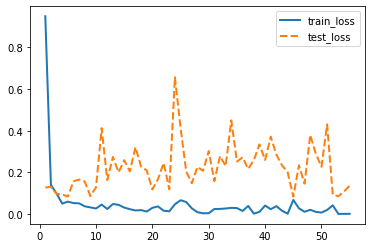

In [83]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss', lw=2)
plt.plot(range(1, epochs+1), test_loss, label='test_loss', lw=2, ls="--")
plt.legend()
plt.savefig('11-6-1.jpg', dpi=400)

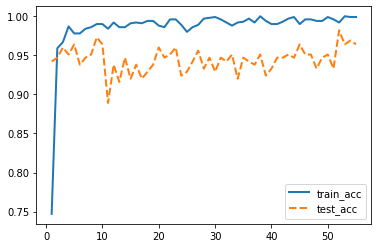

In [84]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc', lw=2)
plt.plot(range(1, epochs+1), test_acc, label='test_acc', ls="--")
plt.legend()
plt.savefig('11-6-2.jpg', dpi=400)

# 添加dropout层

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*10*10)
        x = F.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return x

In [46]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [47]:
epochs = 30

In [48]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

epoch: 0, train_loss: 0.81120, train_acc: 66.8% ,test_loss: 0.71193, test_acc: 70.7%
epoch: 1, train_loss: 0.52835, train_acc: 79.9% ,test_loss: 0.51983, test_acc: 83.1%
epoch: 2, train_loss: 0.45182, train_acc: 82.5% ,test_loss: 0.41476, test_acc: 85.3%
epoch: 3, train_loss: 0.41531, train_acc: 84.6% ,test_loss: 0.59402, test_acc: 75.1%
epoch: 4, train_loss: 0.38094, train_acc: 85.1% ,test_loss: 0.33776, test_acc: 89.8%
epoch: 5, train_loss: 0.28068, train_acc: 90.0% ,test_loss: 0.30465, test_acc: 86.2%
epoch: 6, train_loss: 0.20149, train_acc: 92.8% ,test_loss: 0.45504, test_acc: 85.3%
epoch: 7, train_loss: 0.21863, train_acc: 92.2% ,test_loss: 0.34395, test_acc: 86.2%
epoch: 8, train_loss: 0.19230, train_acc: 91.8% ,test_loss: 0.39637, test_acc: 86.2%
epoch: 9, train_loss: 0.14046, train_acc: 95.2% ,test_loss: 0.31165, test_acc: 92.4%
epoch:10, train_loss: 0.08239, train_acc: 97.2% ,test_loss: 0.35395, test_acc: 88.9%
epoch:11, train_loss: 0.07489, train_acc: 97.9% ,test_loss: 0.401

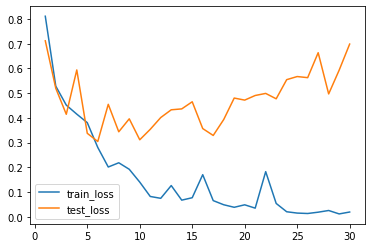

In [49]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

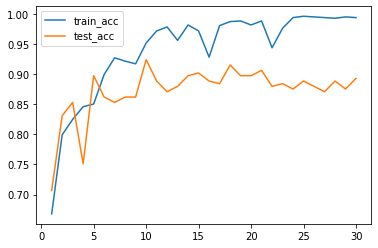

In [50]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 添加BN层

In [66]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*10*10)
        x = F.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return x

In [67]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [68]:
epochs = 30

In [69]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

epoch: 0, train_loss: 0.80418, train_acc: 76.7% ,test_loss: 0.36469, test_acc: 86.7%
epoch: 1, train_loss: 0.37865, train_acc: 88.4% ,test_loss: 0.48814, test_acc: 86.7%
epoch: 2, train_loss: 0.28313, train_acc: 91.0% ,test_loss: 0.56889, test_acc: 86.7%
epoch: 3, train_loss: 0.24833, train_acc: 91.0% ,test_loss: 0.35505, test_acc: 92.0%
epoch: 4, train_loss: 0.25911, train_acc: 95.2% ,test_loss: 0.65936, test_acc: 89.3%
epoch: 5, train_loss: 0.24888, train_acc: 92.8% ,test_loss: 0.58714, test_acc: 84.4%
epoch: 6, train_loss: 0.19619, train_acc: 93.4% ,test_loss: 0.44637, test_acc: 90.7%
epoch: 7, train_loss: 0.14617, train_acc: 95.0% ,test_loss: 0.49194, test_acc: 88.9%
epoch: 8, train_loss: 0.08511, train_acc: 97.9% ,test_loss: 0.55097, test_acc: 88.9%
epoch: 9, train_loss: 0.05943, train_acc: 98.2% ,test_loss: 0.63820, test_acc: 90.2%
epoch:10, train_loss: 0.07594, train_acc: 97.5% ,test_loss: 0.43740, test_acc: 92.0%
epoch:11, train_loss: 0.15665, train_acc: 98.2% ,test_loss: 0.726

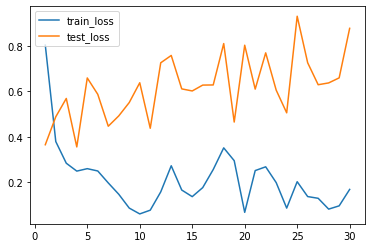

In [70]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

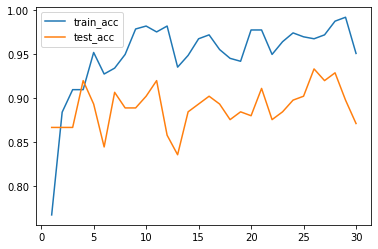

In [71]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

也可以定义一个fit函数，方便直接调用进行训练

In [1]:
def fit(epochs, train_dl, test_dl, model, loss_fn, optimizer, exp_lr_scheduler=None):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, model)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)
        if exp_lr_scheduler:
            exp_lr_scheduler.step()       # 学习速率衰减
    
        template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                    "test_loss: {:.5f}, test_acc: {:.1f}%")
        print(template.format(
              epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
        
    print("Done!")
    return train_loss, test_loss, train_acc, test_acc